# Machine Learning - Project 2 - 2018
## Fatine Benhsain - Tabish Qureshi - Ayyoub El Amrani
### Recommender System

# 1. Introduction

The goal of the project is to create a recommendation systems for movies based on data......bla bla

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Useful starting lines
%matplotlib inline

import numpy as np
import scipy
import scipy.io
import scipy.sparse as sp
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In order to preprocess and use the data, the library pandas is used. The later provides very useful tools in this framework.

# 2. Data Importation & Preprocessing

This step is made for importing data and prepare them before implementing a machine learning method. The preprocessing includes steps such as exploration, wrangling... and can be used for feature engineering.

## 2.1 Training Set Importation

In [3]:
raw_data = pd.read_csv('data/data_train.csv')

Before starting anything, the data will be explored in order to perform data wrangling and features engineering.

In [4]:
raw_data['Prediction'].value_counts()

5    435237
4    324700
3    274327
2     99180
1     43508
Name: Prediction, dtype: int64

In [5]:
raw_data.head()

,Id,Prediction
0,r44_c1,4
1,r61_c1,3
2,r67_c1,4
3,r72_c1,3
4,r86_c1,5


The data are stacked into 2 columns with the Id rX_cY. X corresponds to a user and Y corresponds to the movie.
In order to make a proper analysis, one needs to group users (same X) and the rating (Prediction) on movies (Y).
For this sake, it is necessary to :
1. Unstack the Id and separate X and Y
2. Group the same X (users) as rows with corresponding movies (Y) as columns and the rating as argument of the cell.

We define a method that will split the Id into two columns : _User_ and _Movie_.

In [6]:
def splitting(df,column='Id'):
    '''
        df : the dataframe to split
        column : the column containing the data to split, by default it is the Id column
    '''
    output = df[column].str.split('(\d+)([A-z]+)(\d+)', expand=True)
    output = output.loc[:,[1,3]]
    output.rename(columns={1:'User', 2:'y', 3:'Movie'}, inplace=True)
    output['User'] = output['User'].astype(int)
    output['Movie'] = output['Movie'].astype(int)
    return output

In [7]:
#Splitting of the Id:
split = splitting(raw_data)
split.head()

,User,Movie
0,44,1
1,61,1
2,67,1
3,72,1
4,86,1


In [8]:
split['eval']=raw_data['Prediction']

In [9]:
split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1176952 entries, 0 to 1176951
Data columns (total 3 columns):
User     1176952 non-null int64
Movie    1176952 non-null int64
eval     1176952 non-null int64
dtypes: int64(3)
memory usage: 26.9 MB


Now the splitting is done, one needs to create a table to match users with the movies they rated:

In [10]:
rating_table = split.pivot(index = 'User', columns = 'Movie', values = 'eval')

In [11]:
rating_table.head()

Movie,1,2,3,4,5,6,7,8,9,10,...,991,992,993,994,995,996,997,998,999,1000
User,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,3.0,NaN,5.0,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3.0,3.0
3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,2.0,NaN,NaN,NaN,5.0,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN


<b>Now, the dataset is more readable and it is now possible to start analysis.

## 2.2 Data Preprocessing

### 2.2.1 Data Exploration

It is important to explore the data in order to have an overview of the dataset.

It is possible for example to have an idea of:
* The most/less watched movies
* The most/less well rated
* ...

In [12]:
#Top 10 movies that have been rated:
rating_table.isnull().describe().transpose().sort_values('freq').head(10)

,count,unique,top,freq
Movie,,,,
178,10000,2,True,5410
608,10000,2,True,5510
594,10000,2,True,5597
6,10000,2,True,5653
156,10000,2,True,5687
596,10000,2,True,5723
46,10000,2,True,5742
668,10000,2,True,5798
256,10000,2,True,5894


In [13]:
#Top 10 movies that have not been rated:
rating_table.isnull().describe().transpose().sort_values('freq', ascending = False).head(10)

,count,unique,top,freq
Movie,,,,
955,10000,2,True,9992
928,10000,2,True,9981
468,10000,2,True,9973
784,10000,2,True,9973
946,10000,2,True,9967
709,10000,2,True,9962
758,10000,2,True,9959
243,10000,2,True,9955
957,10000,2,True,9954


In [14]:
rating_table[1].value_counts()

3.0    119
4.0     98
5.0     56
2.0     53
1.0     14
Name: 1, dtype: int64

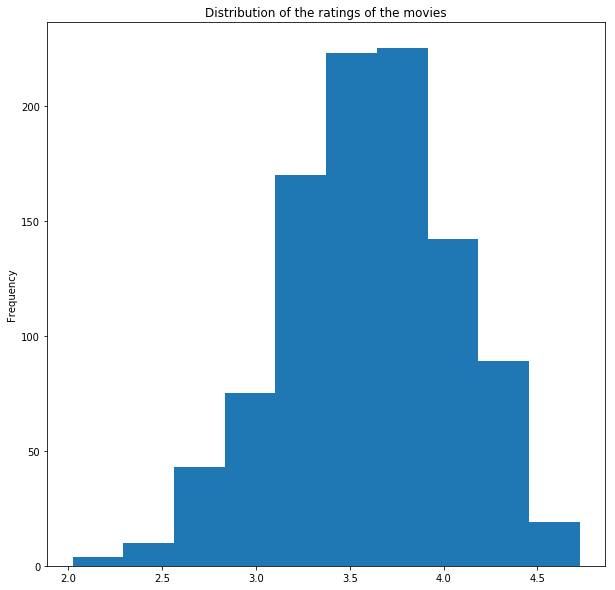

In [15]:
#The distribution of the mean of the rating of each movie
means = split.groupby('Movie').mean()
means = means['eval']
means.plot(kind='hist',figsize=(10,10),title='Distribution of the ratings of the movies')

# 3.2 Alternating Least Squares (ALS)

## Data Loading:

Les fonctions du cours ne sont pas compatibles avec les pandas DF, les données sont donc loadées autrement:

In [16]:
from helpers import load_data, preprocess_data

path_dataset = 'data/data_train.csv'
ratings = load_data(path_dataset)

number of items: 10000, number of users: 1000


In [17]:
test_rating = load_data('data/sample_submission.csv')

test_rating.shape

number of items: 10000, number of users: 1000


(10000, 1000)

## Number of Ratings per Movie & Users:

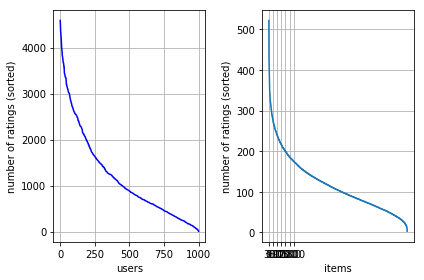

min # of items per user = 8, min # of users per item = 3.


In [18]:
from plots import plot_raw_data

num_items_per_user, num_users_per_item = plot_raw_data(ratings)

print("min # of items per user = {}, min # of users per item = {}.".format(
        min(num_items_per_user), min(num_users_per_item)))

## Splitting the Data between Traning & Testing sets:

In [19]:
def split_data(ratings, num_items_per_user, num_users_per_item,
               min_num_ratings, p_test=0.1):
    """split the ratings to training data and test data.
    Args:
        min_num_ratings: 
            all users and items we keep must have at least min_num_ratings per user and per item. 
    """
    # set seed
    np.random.seed(988)
    
    # select user and item based on the condition.
    valid_users = np.where(num_items_per_user >= 0)[0]
    valid_items = np.where(num_users_per_item >= 0)[0]
    valid_ratings = ratings[valid_items, :][: , valid_users]  
    
    # init
    num_rows, num_cols = valid_ratings.shape
    train = sp.lil_matrix((num_rows, num_cols))
    test = sp.lil_matrix((num_rows, num_cols))
    
    print("the shape of original ratings. (# of row, # of col): {}".format(
        ratings.shape))
    print("the shape of valid ratings. (# of row, # of col): {}".format(
        (num_rows, num_cols)))

    nz_items, nz_users = valid_ratings.nonzero()
    
    # split the data
    for user in set(nz_users):
        # randomly select a subset of ratings
        row, col = valid_ratings[:, user].nonzero()
        selects = np.random.choice(row, size=int(len(row) * p_test))
        residual = list(set(row) - set(selects))

        # add to train set
        train[residual, user] = valid_ratings[residual, user]

        # add to test set
        test[selects, user] = valid_ratings[selects, user]

    print("Total number of nonzero elements in origial data:{v}".format(v=ratings.nnz))
    print("Total number of nonzero elements in train data:{v}".format(v=train.nnz))
    print("Total number of nonzero elements in test data:{v}".format(v=test.nnz))
    return valid_ratings, train, test

the shape of original ratings. (# of row, # of col): (10000, 1000)
the shape of valid ratings. (# of row, # of col): (10000, 1000)
Total number of nonzero elements in origial data:1176952
Total number of nonzero elements in train data:1065327
Total number of nonzero elements in test data:111625


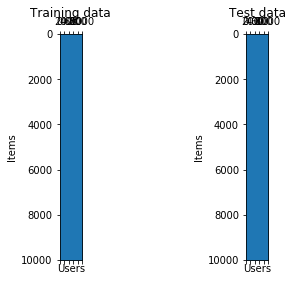

In [20]:
from plots import plot_train_test_data

valid_ratings, train, test = split_data(
    ratings, num_items_per_user, num_users_per_item, min_num_ratings=10, p_test=0.1)
plot_train_test_data(train, test)

## Learn Matrix Factorization using ALS:

In [21]:
from helpers import *

To Perform the ALS model, one needs to initialize the parameters for the Matrix Factorization:

In [22]:
def init_MF(train, num_features):
    """ 
    Source: Lab 10 Solutions
    """
    num_users, num_items = train.shape
    user_features = np.random.rand(num_features, num_users)
    item_features = np.random.rand(num_features, num_items)

    # Sum up each ratings for each movie 
    item_sum = train.sum(axis=0)
    item_nnz = train.getnnz(axis=0)

    # set the first item features to the sum of the ratings divided by the number of nonzero items
    for item_index in range(num_items):
        item_features[0, item_index] = int(item_sum[0, item_index]/item_nnz[item_index])
        
    return user_features, item_features

The function below will update the user-feature matrix Z:

In [23]:
def update_user_feature(train, item_features, num_features, lambda_user, nz_user_itemindices):
    num_users = train.shape[0]
    user_features = np.zeros((num_features, num_users))

    for user, items in nz_user_itemindices:
        W = item_features[:, items]
        
        A = W @ W.T + lambda_user * sp.eye(num_features)
        b = W @ train[user, items].T
        
        x = np.linalg.solve(A, b)
        
        user_features[:, user] = np.copy(x.T)
        
    return user_features

The function below will update the item-feature Matrix W:

In [24]:
def update_item_feature(train, user_features, num_features, lambda_item, nz_item_userindices):

    num_items = train.shape[1]
    item_features = np.zeros((num_features, num_items))

    for item, users in nz_item_userindices:
        W = user_features[:, users]
        
        A = W @ W.T + lambda_item * sp.eye(num_features)
        b = W @ train[users, item]
        
        x = np.linalg.solve(A, b)
        
        item_features[:, item] = np.copy(x.T)
        
    return item_features

Computation of the Mean Squared Error between predictions and nonzero train elements

In [25]:
def compute_error(data, user_features, item_features, nz):

    mse = 0
    pred = np.dot(user_features.T, item_features)
    
    for row, col in nz:
        mse += np.square((data[row, col] - pred[row, col]))

    return np.sqrt(mse/len(nz))

Now, it is possible to perform ALS and compute errors

In [41]:
def calculate_als(train, test, test_ratings, seed=988, num_features=100, m_iter=10, lambda_user=1., lambda_item=0.001, change=1, stop_criterion=1e-8):
    """
    Use Alternating Least Squares (ALS) algorithm to generate predictions
    """
    error_list = [0]
    itr = 0
    np.random.seed(seed)

    # Initialize W and Z with random small numbers
    user_features, item_features = init_MF(train, num_features)
    
    # Group the indices by row or column index
    nz_train, nz_user_itemindices, nz_item_userindices = build_index_groups(train)
    
    while change > stop_criterion and itr < m_iter:
        
        # Update W and Z
        user_features = update_user_feature(train, item_features, num_features, lambda_user, nz_user_itemindices)
        item_features = update_item_feature(train, user_features, num_features, lambda_item, nz_item_userindices)

        rmse = compute_error(train, user_features, item_features, nz_train)
        print("RMSE on training set: {}.".format(rmse))
        change = np.fabs(rmse - error_list[-1])
        error_list.append(rmse)
        itr = itr + 1

    # Calculate the RMSE
    nnz_row, nnz_col = test.nonzero()
    nnz_test = list(zip(nnz_row, nnz_col))
    rmse = compute_error(test, user_features, item_features, nnz_test)
    print("Test RMSE after running ALS: {s}".format(s=rmse))

    num_users = test_ratings.shape[0]
    num_items = test_ratings.shape[1]
    pred_als = sp.lil_matrix((num_users, num_items))
    
    # Multiply the 2 matrices to get X 
    for user in range(num_users):
        for item in range(num_items):
            item_info = item_features[:, item]
            user_info = user_features[:, user]
            pred_als[user, item] = user_info.T.dot(item_info)

    return pred_als

In [42]:
prediction = calculate_als(train, test, test_rating)

RMSE on training set: 0.5165792471190594.
RMSE on training set: 0.45078483311556367.
RMSE on training set: 0.4134188553539601.
RMSE on training set: 0.3885228904424945.
RMSE on training set: 0.37045584940319326.
RMSE on training set: 0.356595685781783.
RMSE on training set: 0.3455219972733786.
RMSE on training set: 0.3364115309682095.
RMSE on training set: 0.32875315885219364.
RMSE on training set: 0.3222042346148988.
Test RMSE after running ALS: 1.7476087132701938


In [43]:
print(prediction[:10,10:])

  (0, 0)	4.118498621668685
  (0, 1)	3.0777171890904356
  (0, 2)	3.602878462381751
  (0, 3)	3.637776159571354
  (0, 4)	4.417791280257791
  (0, 5)	3.031190551748484
  (0, 6)	3.14733375348224
  (0, 7)	4.567302888265083
  (0, 8)	4.606485059974284
  (0, 9)	3.4757131921331794
  (0, 10)	3.6294102636995156
  (0, 11)	2.984326121457493
  (0, 12)	4.532591466905607
  (0, 13)	3.052916056314635
  (0, 14)	2.9720057398401787
  (0, 15)	4.367639265511055
  (0, 16)	4.697574149280365
  (0, 17)	3.2176173743118515
  (0, 18)	3.622523810198915
  (0, 19)	4.002950596824025
  (0, 20)	3.062438280437821
  (0, 21)	3.5882543866329564
  (0, 22)	2.833262360941087
  (0, 23)	3.943469803163337
  (0, 24)	3.9109089113516626
  (0, 25)	4.700175016148367
  (0, 26)	3.9466908849451863
  (0, 27)	2.8701148971874586
  (0, 28)	2.705645727522983
  (0, 29)	3.2431471941588805
  (0, 30)	2.7315846131370574
  (0, 31)	3.543891916941663
  (0, 32)	2.5094491022615686
  (0, 33)	3.4793339362836466
  (0, 34)	5.1388166296232605
  (0, 35)	4.73297

# 4. Predictions on the submission

We first open the csv containing the sample in order to obtain the testing data, we then split this data to get the users and movies in seperate columns using our defined method.

In [ ]:
submission = pd.read_csv('data/sample_submission.csv')

In [ ]:
submission.head()

In [ ]:
test = splitting(submission)